# BELL STATE

In [117]:
import torch
from torch import nn
import numpy as np
from qibo import Circuit, gates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import datetime

In [118]:
def build_new_entangled_circuit(x_input, thetas):
    """
    Build a 2-qubit circuit that prepares either |00⟩ or |Φ⁺⟩
    and then applies a rotation and measures *one* qubit.

    Args:
        x_input: 0 for |00⟩, 1 for |Φ⁺⟩
    """

    assert len(thetas) == 12, "Require 4 parameters for this ansatz"
    
    circuit = Circuit(2)
    
    # --- Prepare input state ---
    if x_input == 1:
        # Prepare Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
        circuit.add(gates.H(0))
        circuit.add(gates.CNOT(0, 1))
    else:
        # Prepare |00⟩
        pass  # Already |00⟩
        
        
    for i in range(6):

        circuit.add(gates.CNOT(0, 1))

        circuit.add(gates.RY(0, thetas[2*i + 0]))

        circuit.add(gates.RY(1, thetas[2*i + 1]))    

    
    # --- Measurement ---
    circuit.add(gates.M(0, 1))
    
    return circuit


def parameter_shift_rule(x_input, thetas, label, n_shots, shift=np.pi/2):
    n_params = len(thetas)
    grad = np.zeros(n_params)

    for i in range(n_params):
        # Create shifted parameter vectors
        theta_plus = thetas.copy()
        theta_minus = thetas.copy()
        theta_plus[i] += shift
        theta_minus[i] -= shift

        # Evaluate circuit at shifted parameters
        result_plus = build_new_entangled_circuit(x_input, theta_plus)(nshots=n_shots)
        counts_plus = result_plus.frequencies()
        # print("counts_plus", counts_plus)
        
        result_minus = build_new_entangled_circuit(x_input, theta_minus)(nshots=n_shots)
        counts_minus = result_minus.frequencies()    
        

        # Map measurement outcomes to class probabilities
        mapping = {"00":0, "01":1, "10":1, "11":1}
        p_plus = np.zeros(3)
        p_minus = np.zeros(3)
        for bitstring, freq in counts_plus.items():
            if bitstring in mapping:
                p_plus[mapping[bitstring]] += freq / n_shots
        for bitstring, freq in counts_minus.items():
            if bitstring in mapping:
                p_minus[mapping[bitstring]] += freq / n_shots

        # Clip to avoid log(0)
        eps = 1e-8
        p_plus = np.clip(p_plus, eps, 1 - eps)
        p_minus = np.clip(p_minus, eps, 1 - eps)

        # Cross-entropy loss
        loss_plus = -np.log(p_plus[label])
        # loss_plus = permutation_invariant_loss_single(p_plus, label)

        loss_minus = -np.log(p_minus[label])
        # loss_minus = permutation_invariant_loss_single(p_minus, label)

        # Parameter-shift gradient
        grad[i] = 0.5 * (loss_plus - loss_minus)

    return grad


class QuantumModel(torch.nn.Module):
    def __init__(self, n_parameters=12):
        super().__init__()
        self.thetas = nn.ParameterList([
                    nn.Parameter(torch.tensor(np.round(np.random.uniform(0, 2*np.pi), 5))) for _ in range(n_parameters)
                    ])

    # def forward(self, x_input, n_shots):
    def forward(self, x_input, n_shots):

        params = []
        
        for param in self.thetas:
            params.append(param.item())
            
        circuit = build_new_entangled_circuit(x_input, params)
        result = circuit(nshots=n_shots)
        
        return result
        # return circuit

In [119]:
class Client:
    def __init__(self, num_samples, seed, n_shots, vqc_class=QuantumModel, sigma=0):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.sample_pointer = 0  
        self.n_shots = n_shots  # Number of shots for gradient calculation

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        raw_bias = np.random.normal(0, self.sigma)
        prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
        labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])

        self.labels = labels

        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}

    def set_thetas(self, new_thetas):
        """
        Set the VQC parameters from a numpy array or list.
        new_thetas: array-like of length n_parameters
        """
        with torch.no_grad():
            for i, param in enumerate(self.model.thetas):
                param.copy_(torch.tensor(new_thetas[i], dtype=param.dtype))
    
    
    def get_thetas(self):
        """
        Return the current VQC parameters as a numpy array.
        """
        return np.array([param.detach().cpu().numpy() for param in self.model.thetas])

        
    def local_train(self, batch_size, lr=0.1):
        """
        Local training for a batch of data using parameter-shift gradients.
        Works with multi-parameter, multi-class VQC.
        """
        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_thetas()  # No more data
    
        training_data = self.labels[start:end]
        theta_history = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    
        local_weights_evolution_aux = []

        # start = datetime.datetime.now()
        for epoch, label in enumerate(training_data):
            x_input = label  # For trine states, label ∈ {0,1,2}
    
            optimizer.zero_grad()
    
            # Estimate gradient via multi-parameter parameter-shift
            
            # print(f"Grad estimation at {start}")
            grad_estimate = parameter_shift_rule(
                x_input, 
                self.get_thetas(), 
                label,
                n_shots=self.n_shots
            )
            # grad_estimate = parameter_shift_rule_parallel(
            #         x_input, self.get_thetas(), label, self.n_shots, max_workers=8
            #     )
            # print(f"Grad estimation took {(datetime.datetime.now() - start).total_seconds()} seconds")
            # print(grad_estimate)
    
            # Manually assign gradients to all parameters
            for i, param in enumerate(self.model.thetas):
                param.grad = torch.tensor(grad_estimate[i], dtype=param.dtype)
    
            optimizer.step()
            # print(f"1 sample processing took {(datetime.datetime.now() - start).total_seconds()} seconds")
        # print(f"1 local client train took {(datetime.datetime.now() - start).total_seconds()} seconds")


In [120]:
def create_clients_setup(num_clients, num_samples, n_shots, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [121]:
def compute_Psuccess(client, num_samples_test=1000000):
    Ps00 = client.model(0, n_shots=num_samples_test).frequencies()['00']/num_samples_test
    Ps01 = client.model(1, n_shots=num_samples_test).frequencies()['01']/num_samples_test
    Ps10 = client.model(1, n_shots=num_samples_test).frequencies()['10']/num_samples_test
    Ps11 = client.model(1, n_shots=num_samples_test).frequencies()['11']/num_samples_test
    
    Ps0 = Ps00
    Ps1 = Ps01 + Ps10 + Ps11

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [122]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

            for client in clients:
                client._generate_labels()
                client.local_train(client.num_samples, lr=lr)
                client_psuc = np.round(compute_Psuccess(client), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [123]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [124]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x, axis=0)
    mean_y = np.mean(y, axis=0)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [125]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size):
    # avg_params = []
    for rnd in range(num_rounds):
        avg_params = []
        # print(f"\n--- Round {rnd+1} ---")

        local_weights = []

        for client in clients:
            client.local_train(batch_size=local_batch_size, lr=lr)
            avg_params.append(client.get_thetas())

        # Federated averaging
        global_thetas = average_angles_modulo(avg_params)

        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_thetas(global_thetas)
        # print(client.get_thetas())

In [126]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

            for client in clients:
                client._generate_labels()

            run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None, None)
            QFL_client.set_thetas(clients[0].get_thetas())
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [127]:
optimal_client = Client(None, None, None)
optimal_client.set_thetas([0]*12)
compute_Psuccess(optimal_client)

0.749824

In [128]:
n_shots = 1

## Setup 1 (x5): 10 clients, 50x5 = 250 samples

In [129]:
num_clients = 10
num_samples = 250

### $\sigma=4.0$

In [130]:
sigma_range = (4.0, 4.0)

#### QFL

In [131]:
#### SETUP PARAMETER
num_rounds = 5
local_batch_size = 50

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [132]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 3, 10, 11, 11, 885046)

In [133]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 50
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


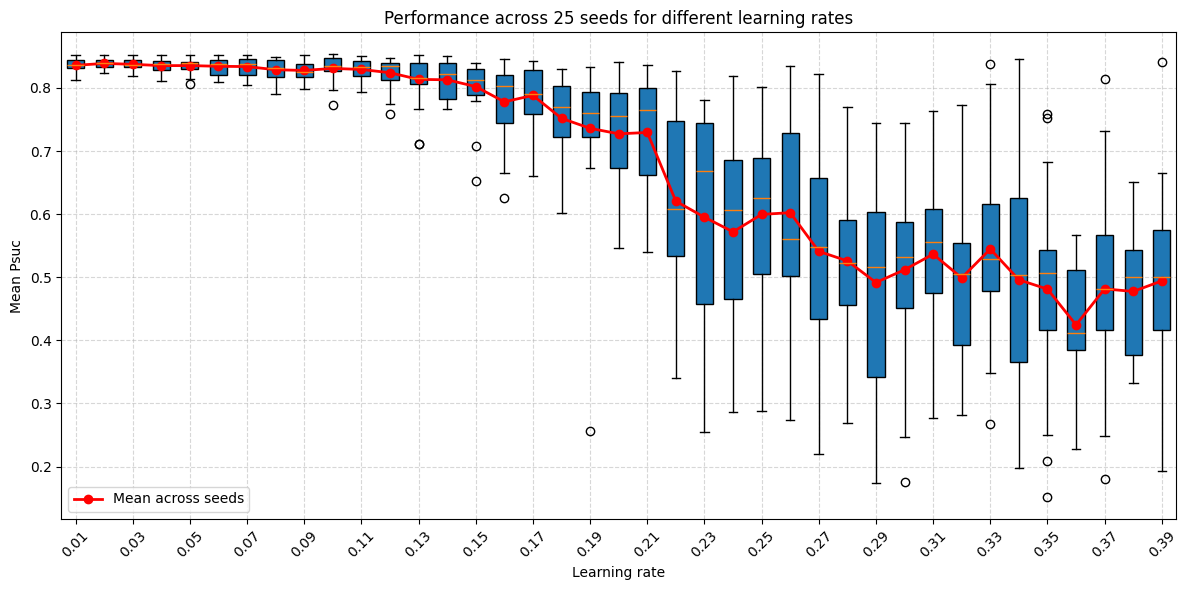

Best learning rate: 0.02 with mean Psuc = 0.8388


In [134]:
opt_lr_qfl_s4_setup1 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [135]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 50

lr_values = [opt_lr_qfl_s4_setup1]
seeds = np.arange(1000, 1100)

In [136]:
QFL_Psucs_s4_setup1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 50
 - lr: [np.float64(0.02)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [137]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 4, 1, 28, 56, 66440)

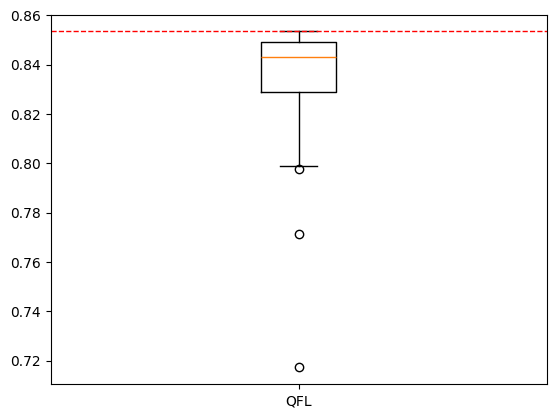

In [138]:
plt.boxplot([QFL_Psucs_s4_setup1.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [139]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [140]:
all_mean_Psucs, all_min_Psucs = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


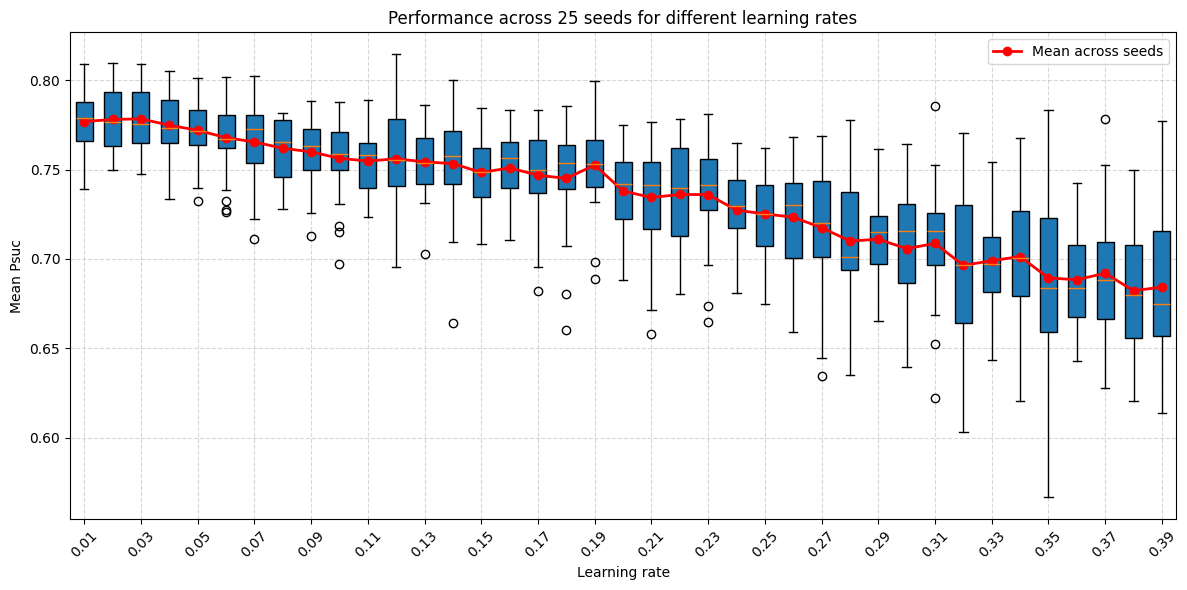

Best learning rate: 0.03 with mean Psuc = 0.7783


In [141]:
opt_lr_1s_s4_setup1 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [142]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup1]
seeds = np.arange(0, 100)

In [143]:
all_mean_Psucs_1s_s4_setup1, all_min_Psucs_1s_s4_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.03)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


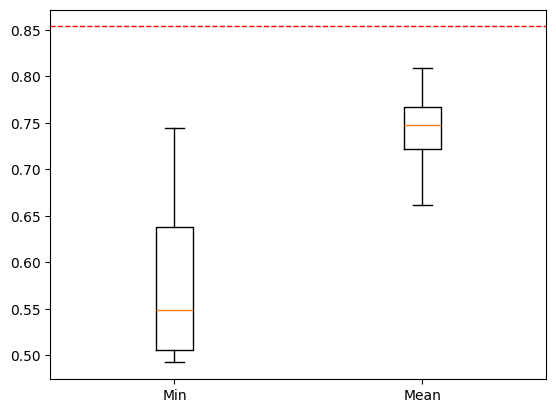

In [144]:
plt.boxplot([all_min_Psucs_1s_s4_setup1.flatten(), all_mean_Psucs_1s_s4_setup1.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Comparisons

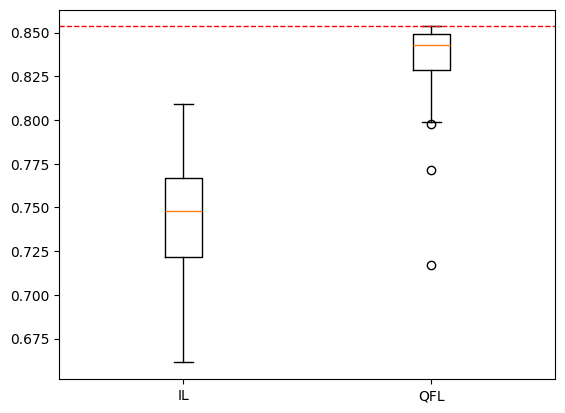

In [145]:
plt.boxplot([all_mean_Psucs_1s_s4_setup1.flatten(), QFL_Psucs_s4_setup1.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

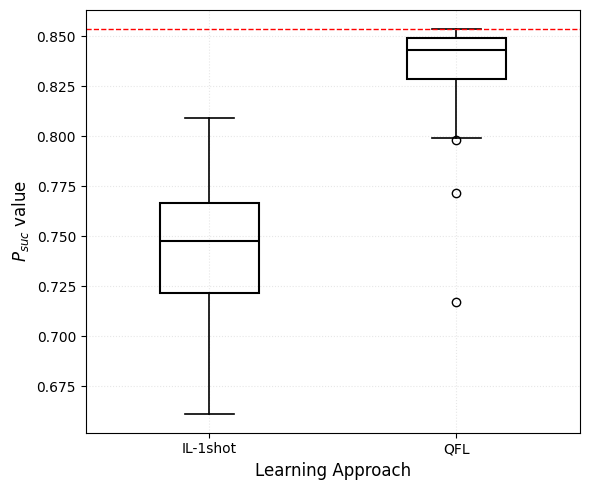

In [146]:
# Data
data = [all_mean_Psucs_1s_s4_setup1.flatten(), QFL_Psucs_s4_setup1.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
#plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("bell_setup1_sigma4.png", dpi=600, bbox_inches="tight")
plt.show()

In [147]:
print(np.mean(all_mean_Psucs_1s_s4_setup1))
print(np.mean(QFL_Psucs_s4_setup1))

0.7426341000000001
0.836224


In [148]:
print(np.min(all_mean_Psucs_1s_s4_setup1), np.max(all_mean_Psucs_1s_s4_setup1))
print(np.min(QFL_Psucs_s4_setup1), np.max(QFL_Psucs_s4_setup1))

0.66135 0.80895
0.7173 0.8535


## Setup 2 (x5): 10 clients, 25x5 = 125 samples

In [149]:
num_clients = 10
num_samples = 125

### $\sigma=4.0$

In [150]:
sigma_range = (4.0, 4.0)

#### QFL

In [151]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 25

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [152]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 4, 16, 53, 17, 733228)

In [153]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 25
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


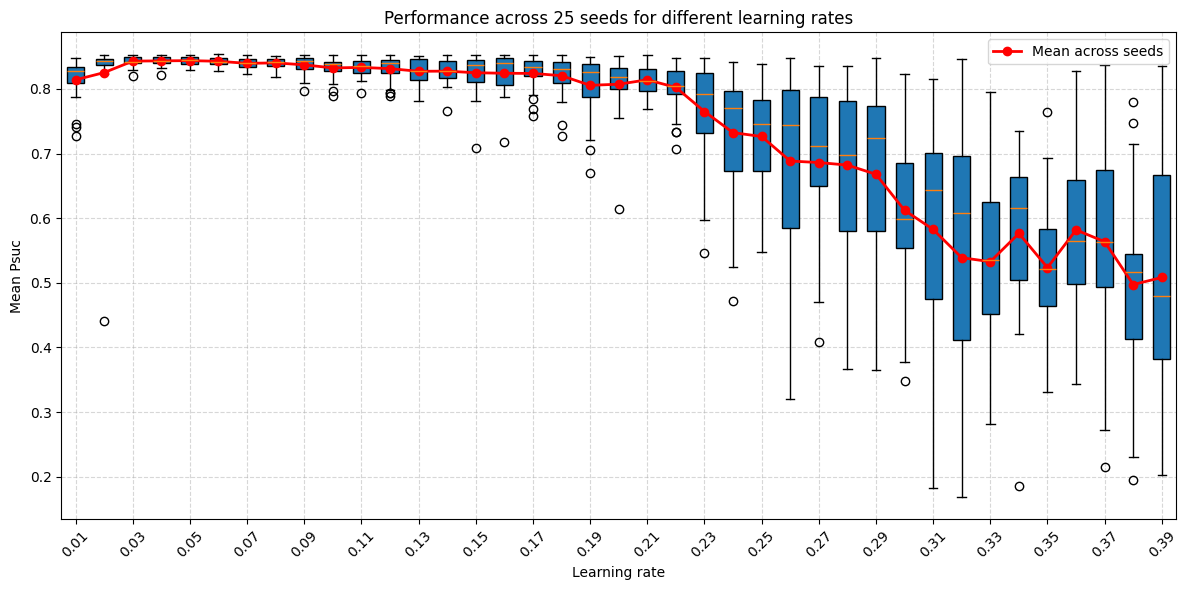

Best learning rate: 0.05 with mean Psuc = 0.8437


In [154]:
opt_lr_qfl_s4_setup2 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [155]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 25

lr_values = [opt_lr_qfl_s4_setup2]
seeds = np.arange(1000, 1100)

In [156]:
QFL_Psucs_s4_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 25
 - lr: [np.float64(0.05)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [157]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 5, 0, 31, 21, 343114)

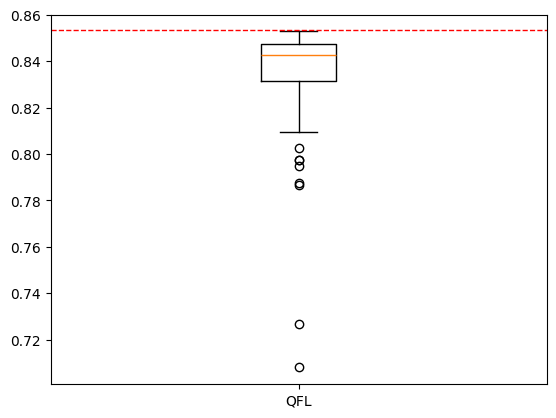

In [158]:
plt.boxplot([QFL_Psucs_s4_setup2.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [159]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [160]:
all_mean_Psucs, all_min_Psucs  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


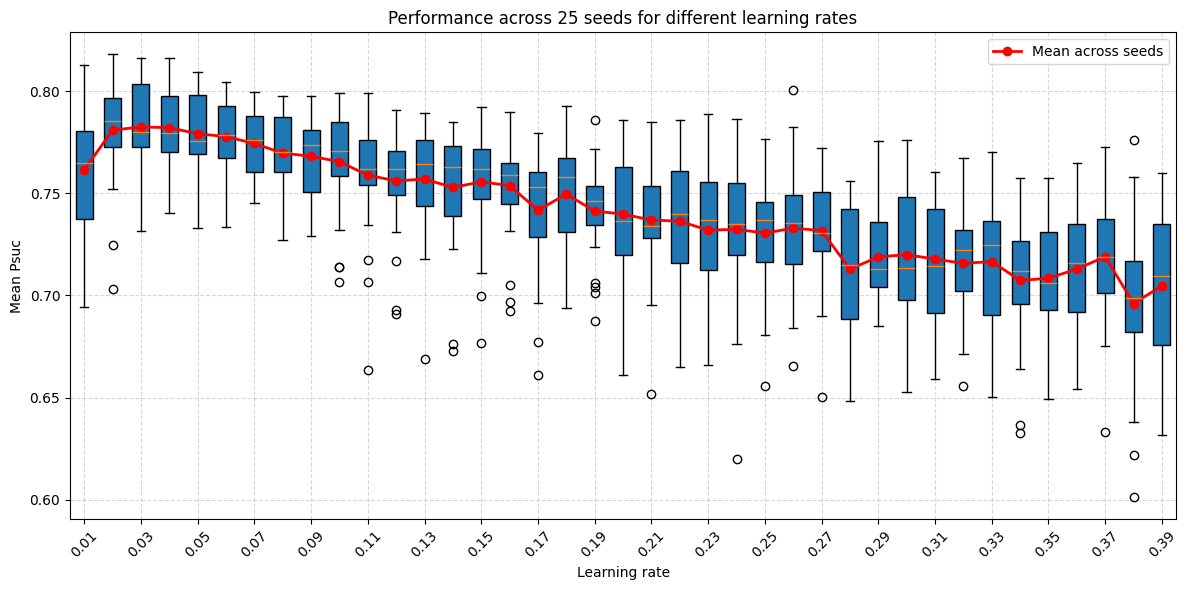

Best learning rate: 0.03 with mean Psuc = 0.7824


In [161]:
opt_lr_1s_s4_setup2 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [162]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup2]
seeds = np.arange(0, 100)

In [163]:
all_mean_Psucs_1s_s4_setup2, all_min_Psucs_1s_s4_setup2  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.03)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


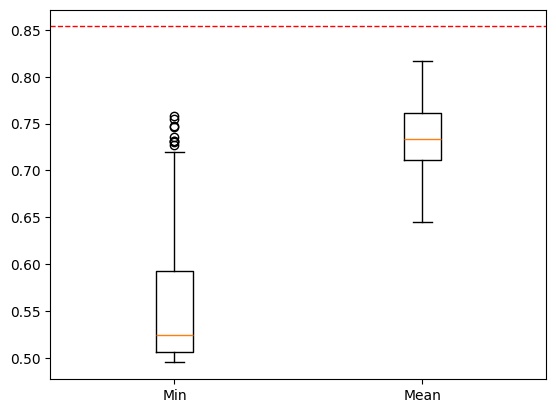

In [164]:
plt.boxplot([all_min_Psucs_1s_s4_setup2.flatten(), all_mean_Psucs_1s_s4_setup2.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Comparisons

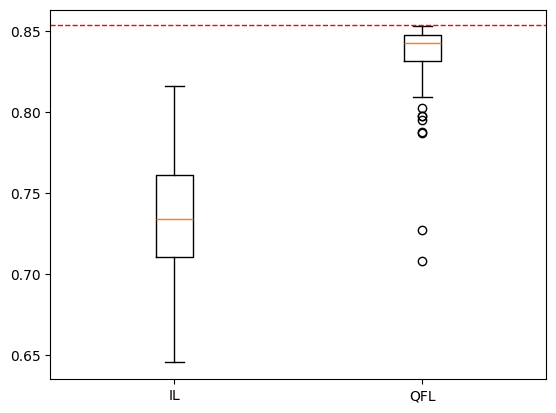

In [165]:
plt.boxplot([all_mean_Psucs_1s_s4_setup2.flatten(), QFL_Psucs_s4_setup2.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

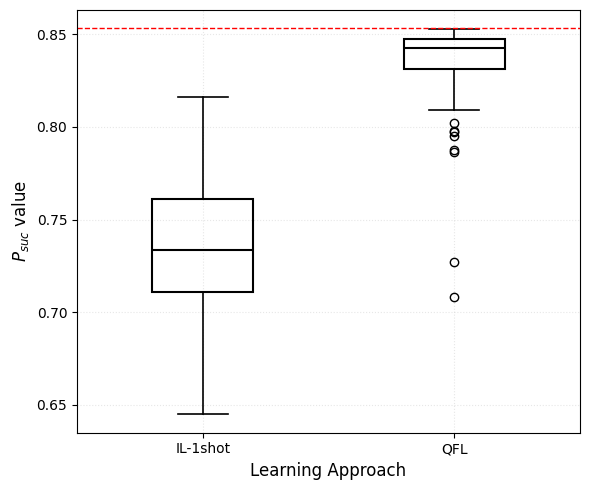

In [166]:
# Data
data = [all_mean_Psucs_1s_s4_setup2.flatten(), QFL_Psucs_s4_setup2.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
#plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("bell_setup2_sigma4.png", dpi=600, bbox_inches="tight")
plt.show()

In [167]:
print(np.mean(all_mean_Psucs_1s_s4_setup2))
print(np.mean(QFL_Psucs_s4_setup2))

0.7356199
0.8343860000000001


In [168]:
print(np.min(all_mean_Psucs_1s_s4_setup2), np.max(all_mean_Psucs_1s_s4_setup2))
print(np.min(QFL_Psucs_s4_setup2), np.max(QFL_Psucs_s4_setup2))

0.64526 0.8162200000000001
0.708 0.8528


## Setup 4 (x5): 25 clients, 5x5 = 25 samples

In [169]:
num_clients = 25
num_samples = 25

### $\sigma=1.0$

In [170]:
sigma_range = (1.0, 1.0)

#### QFL

In [171]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [172]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 5, 8, 20, 49, 797520)

In [173]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


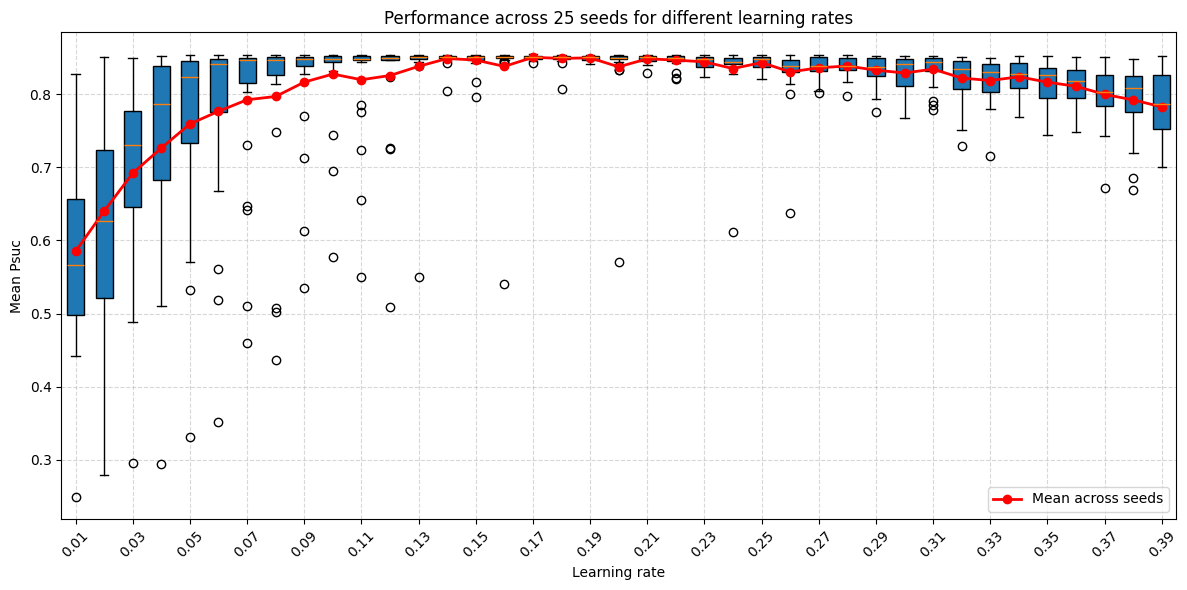

Best learning rate: 0.17 with mean Psuc = 0.8502


In [174]:
opt_lr_qfl_s1_setup4 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [175]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup4]
seeds = np.arange(1000, 1100)

In [176]:
QFL_Psucs_s1_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [np.float64(0.17)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [177]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 5, 12, 12, 27, 997866)

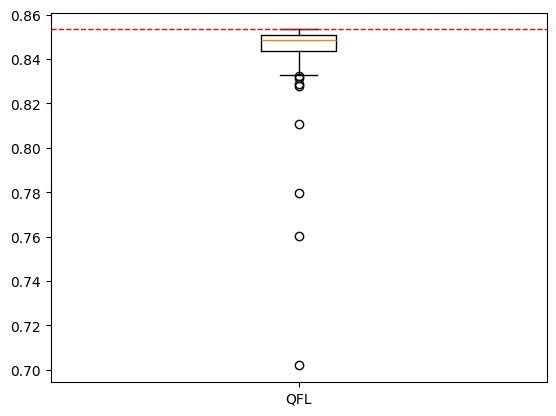

In [178]:
plt.boxplot([QFL_Psucs_s1_setup4.flatten()], tick_labels=["QFL"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [179]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [180]:
all_mean_Psucs, all_min_Psucs  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


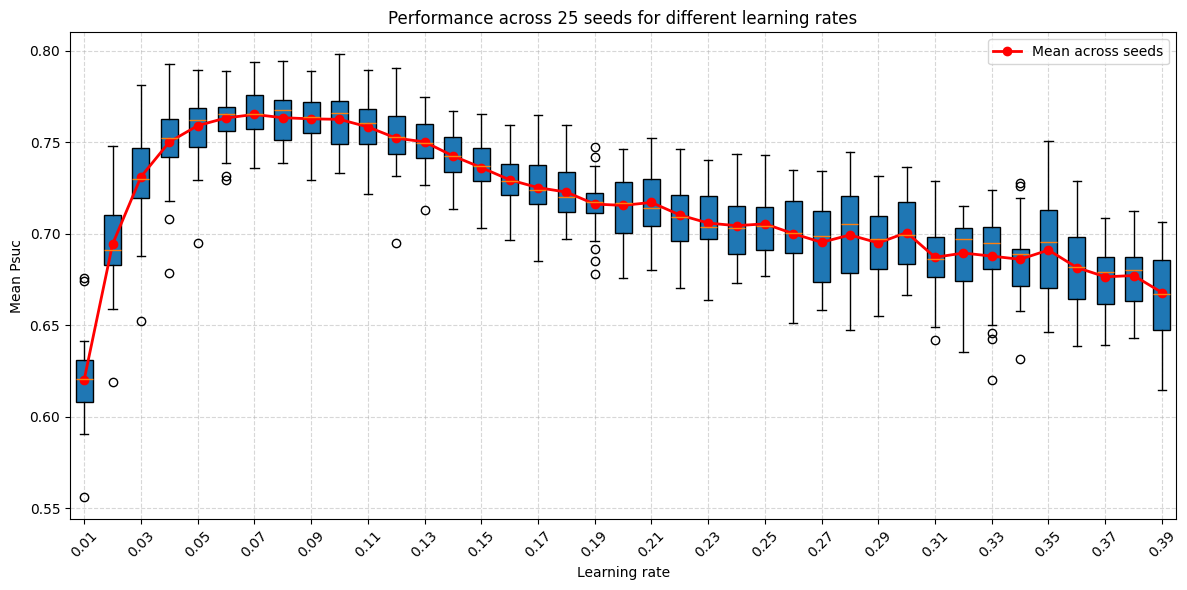

Best learning rate: 0.07 with mean Psuc = 0.7652


In [181]:
opt_lr_1s_s1_setup4 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [182]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup4]
seeds = np.arange(0, 100)

In [183]:
all_mean_Psucs_1s_s1_setup4, all_min_Psucs_1s_s1_setup4  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [np.float64(0.07)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


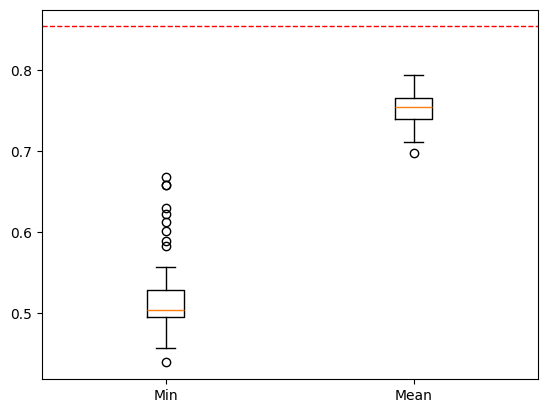

In [184]:
plt.boxplot([all_min_Psucs_1s_s1_setup4.flatten(), all_mean_Psucs_1s_s1_setup4.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Comparisons

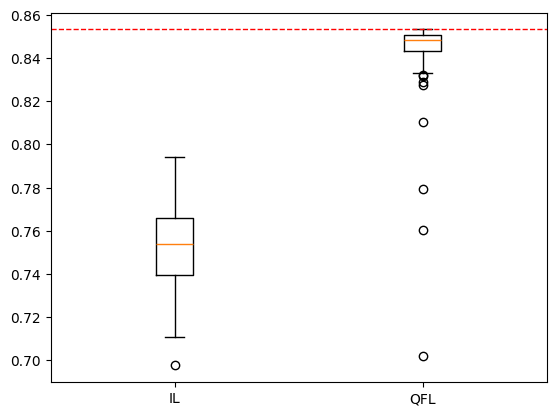

In [185]:
plt.boxplot([all_mean_Psucs_1s_s1_setup4.flatten(), QFL_Psucs_s1_setup4.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

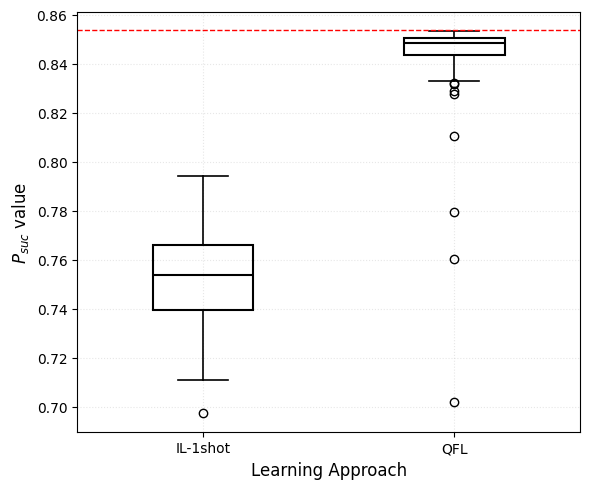

In [186]:
# Data
data = [all_mean_Psucs_1s_s1_setup4.flatten(), QFL_Psucs_s1_setup4.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
#plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("bell_setup4_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [187]:
print(np.mean(all_mean_Psucs_1s_s1_setup4))
print(np.mean(QFL_Psucs_s1_setup4))

0.7514585999999999
0.8434559999999999


In [188]:
print(np.min(all_mean_Psucs_1s_s1_setup4), np.max(all_mean_Psucs_1s_s1_setup4))
print(np.min(QFL_Psucs_s1_setup4), np.max(QFL_Psucs_s1_setup4))

0.6976 0.794124
0.7019 0.8533


## Setup 5 (x5): 50 clients, 5x5 = 25 samples

In [189]:
num_clients = 50
num_samples = 25

### $\sigma=1.0$

In [190]:
sigma_range = (1.0, 1.0)

#### QFL

In [191]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [192]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 5, 16, 37, 56, 245199)

In [193]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


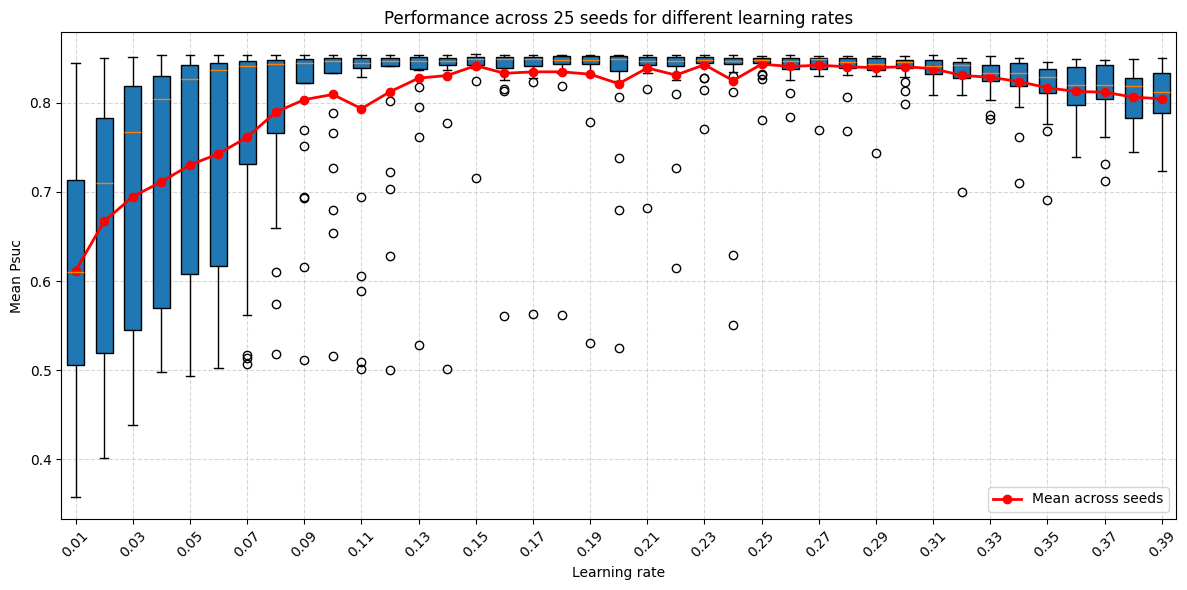

Best learning rate: 0.25 with mean Psuc = 0.8431


In [194]:
opt_lr_qfl_s1_setup5 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [195]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup5]
seeds = np.arange(1000, 1100)

In [196]:
QFL_Psucs_s1_setup5 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [np.float64(0.25)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [197]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 6, 0, 21, 25, 731397)

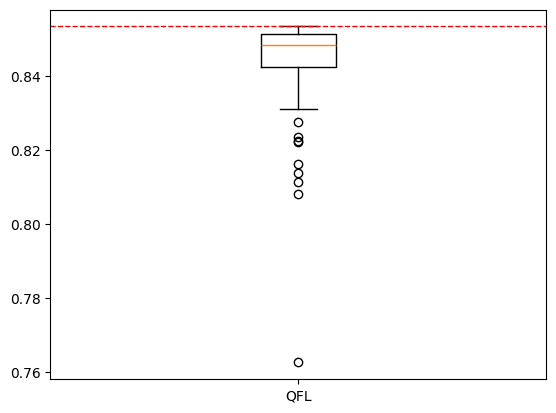

In [198]:
plt.boxplot([QFL_Psucs_s1_setup5.flatten()], tick_labels=["QFL"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [199]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [200]:
all_mean_Psucs, all_min_Psucs  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


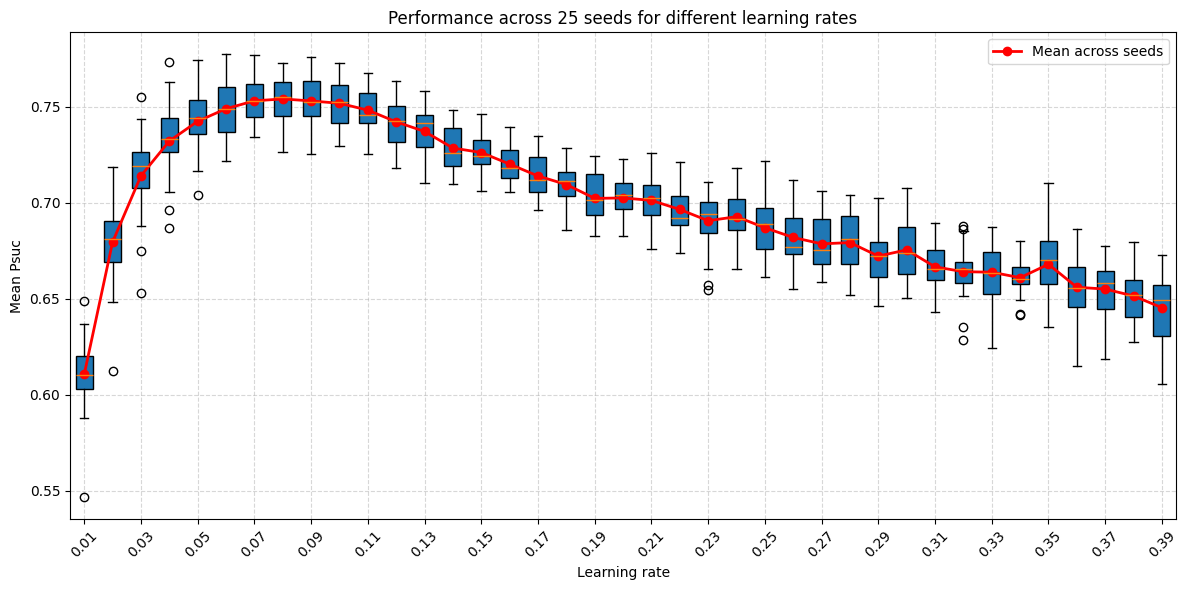

Best learning rate: 0.08 with mean Psuc = 0.7540


In [201]:
opt_lr_1s_s1_setup5 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [202]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup5]
seeds = np.arange(0, 100)

In [203]:
all_mean_Psucs_1s_s1_setup5, all_min_Psucs_1s_s1_setup5  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [np.float64(0.08)]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


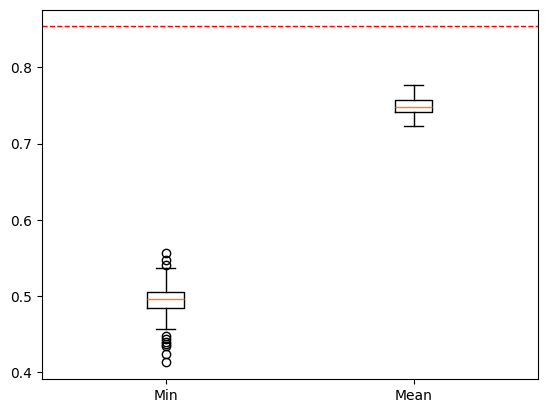

In [204]:
plt.boxplot([all_min_Psucs_1s_s1_setup5.flatten(), all_mean_Psucs_1s_s1_setup5.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Comparisons

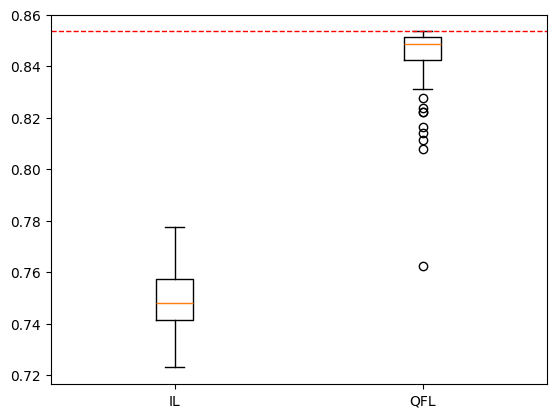

In [205]:
plt.boxplot([all_mean_Psucs_1s_s1_setup5.flatten(), QFL_Psucs_s1_setup5.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

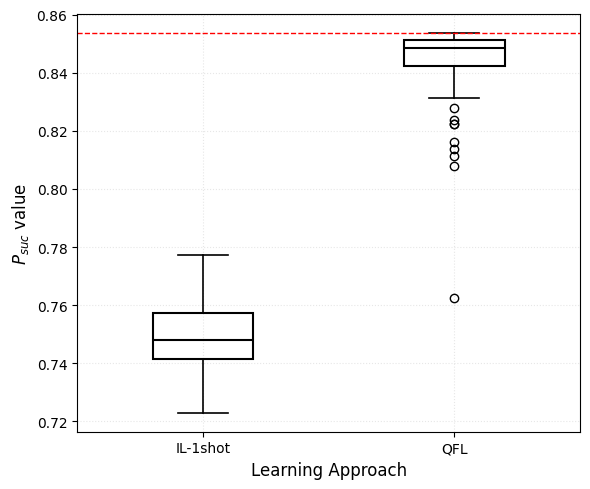

In [206]:
# Data
data = [all_mean_Psucs_1s_s1_setup5.flatten(), QFL_Psucs_s1_setup5.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
#plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("bell_setup5_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [207]:
print(np.mean(all_mean_Psucs_1s_s1_setup5))
print(np.mean(QFL_Psucs_s1_setup5))

0.7484721800000002
0.844253


In [208]:
print(np.min(all_mean_Psucs_1s_s1_setup5), np.max(all_mean_Psucs_1s_s1_setup5))
print(np.min(QFL_Psucs_s1_setup5), np.max(QFL_Psucs_s1_setup5))

0.7229979999999999 0.7774260000000001
0.7625 0.8535


## Setup 1 ORIGINAL: 10 clients, 50 samples

In [209]:
num_clients = 10
num_samples = 50

### $\sigma=4.0$

In [210]:
sigma_range = (4.0, 4.0)

#### QFL

In [211]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [212]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 6, 9, 13, 23, 664607)

In [213]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


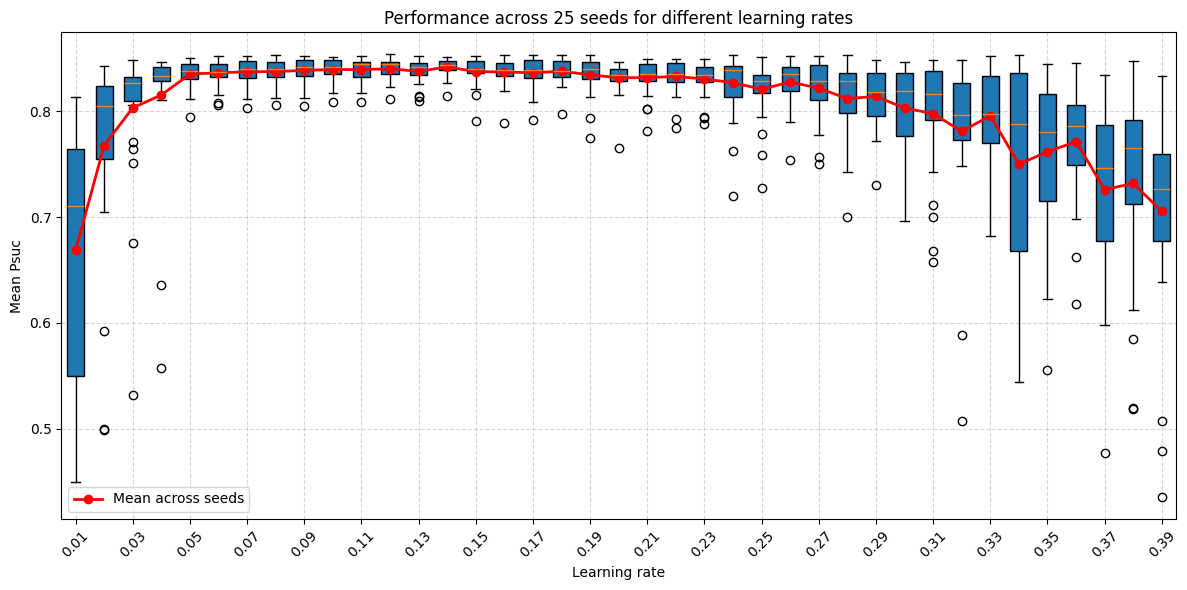

Best learning rate: 0.14 with mean Psuc = 0.8420


In [214]:
opt_lr_qfl_s4_setup1o = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [215]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [opt_lr_qfl_s4_setup1o]
seeds = np.arange(1000, 1100)

In [216]:
QFL_Psucs_s4_setup1o = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [np.float64(0.14)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [217]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 6, 12, 17, 34, 115703)

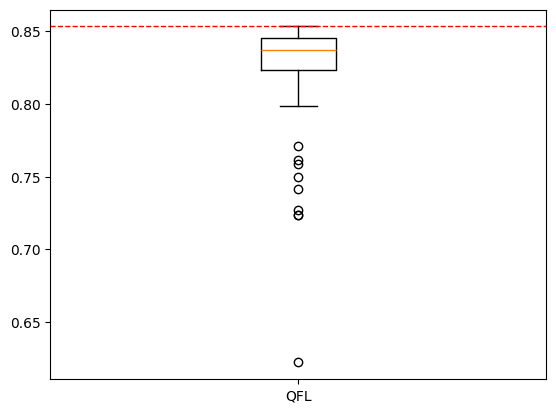

In [218]:
plt.boxplot([QFL_Psucs_s4_setup1o.flatten()], tick_labels=["QFL"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [219]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [220]:
all_mean_Psucs, all_min_Psucs  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6


KeyboardInterrupt: 

In [ ]:
opt_lr_1s_s4_setup1o = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [ ]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup1o]
seeds = np.arange(0, 100)

In [ ]:
all_mean_Psucs_1s_s4_setup1o, all_min_Psucs_1s_s4_setup1o  = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

In [ ]:
plt.boxplot([all_min_Psucs_1s_s4_setup1o.flatten(), all_mean_Psucs_1s_s4_setup1o.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

#### Comparisons

In [ ]:
plt.boxplot([all_mean_Psucs_1s_s4_setup1o.flatten(), QFL_Psucs_s4_setup1o.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y= 0.8536, color='r', linestyle='--', linewidth=1)
plt.show()

In [ ]:
# Data
data = [all_mean_Psucs_1s_s4_setup1o.flatten(), QFL_Psucs_s4_setup1o.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
#plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("bell_setup1o_sigma4.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
print(np.mean(all_mean_Psucs_1s_s4_setup1o))
print(np.mean(QFL_Psucs_s4_setup1o))

In [ ]:
print(np.min(all_mean_Psucs_1s_s4_setup1o), np.max(all_mean_Psucs_1s_s4_setup1o))
print(np.min(QFL_Psucs_s4_setup1o), np.max(QFL_Psucs_s4_setup1o))

# Cross-plots

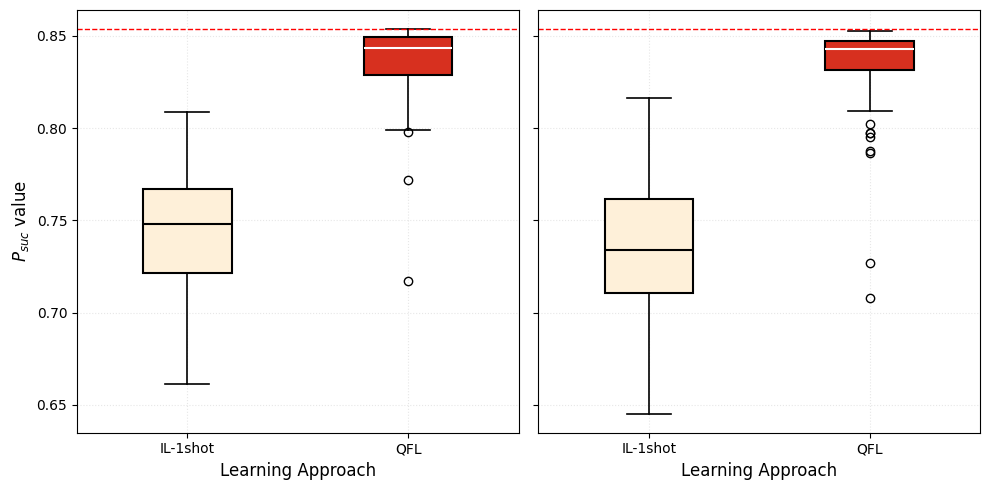

In [224]:
import matplotlib.pyplot as plt

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

labels = ["IL-1shot", "QFL"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# ---------- PLOT 1 ----------
data1 = [
    all_mean_Psucs_1s_s4_setup1.flatten(),
    QFL_Psucs_s4_setup1.flatten()
]

bp1 = axes[0].boxplot(
    data1,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[0].axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
axes[0].set_ylabel(r"$P_{suc}$ value", fontsize=12)
axes[0].set_xlabel("Learning Approach", fontsize=12)
axes[0].grid(True, linestyle=":", alpha=0.3)
#axes[0].set_title("Setup 1")

# ---------- PLOT 2 ----------
data2 = [
    all_mean_Psucs_1s_s4_setup2.flatten(),
    QFL_Psucs_s4_setup2.flatten()
]

bp2 = axes[1].boxplot(
    data2,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[1].axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel("Learning Approach", fontsize=12)
axes[1].grid(True, linestyle=":", alpha=0.3)
#axes[1].set_title("Setup 2")

# Hide y-axis labels (numbers) on the right subplot, keep ticks
axes[1].tick_params(axis='y', labelleft=False)

# Color boxes
bp1['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp1['boxes'][1].set_facecolor("#d7301f")  # QFL
bp2['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp2['boxes'][1].set_facecolor("#d7301f")  # QFL

# Color medians
bp1['medians'][0].set_color("black")      # IL-1shot median
bp1['medians'][1].set_color("white")      # QFL median
bp2['medians'][0].set_color("black")      # IL-1shot median
bp2['medians'][1].set_color("white")      # QFL median



plt.tight_layout()
plt.savefig("bell_setups12_sigma4.png", dpi=600, bbox_inches="tight")
plt.show()

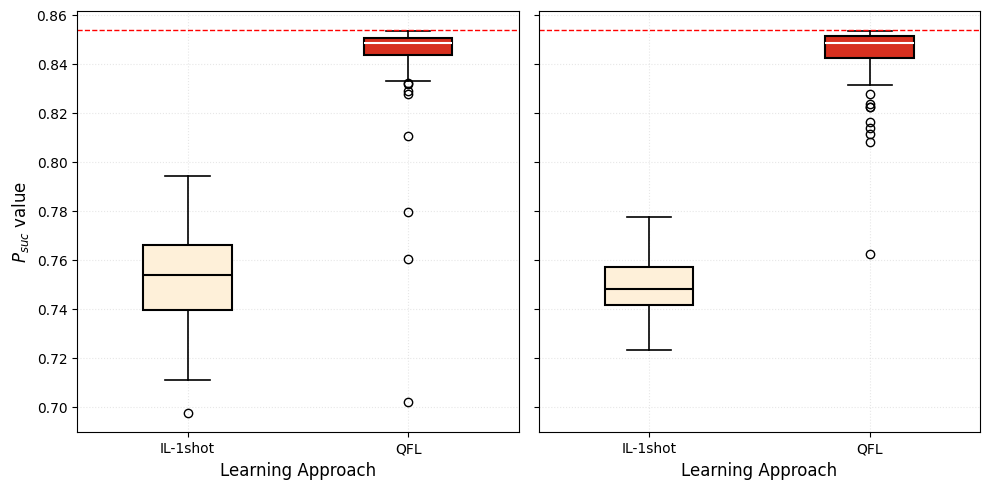

In [225]:
import matplotlib.pyplot as plt

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

labels = ["IL-1shot", "QFL"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# ---------- PLOT 1 ----------
data1 = [
    all_mean_Psucs_1s_s1_setup4.flatten(),
    QFL_Psucs_s1_setup4.flatten()
]

bp1 = axes[0].boxplot(
    data1,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[0].axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
axes[0].set_ylabel(r"$P_{suc}$ value", fontsize=12)
axes[0].set_xlabel("Learning Approach", fontsize=12)
axes[0].grid(True, linestyle=":", alpha=0.3)
#axes[0].set_title("Setup 1")

# ---------- PLOT 2 ----------
data2 = [
    all_mean_Psucs_1s_s1_setup5.flatten(),
    QFL_Psucs_s1_setup5.flatten()
]

bp2 = axes[1].boxplot(
    data2,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[1].axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel("Learning Approach", fontsize=12)
axes[1].grid(True, linestyle=":", alpha=0.3)
#axes[1].set_title("Setup 2")

# Hide y-axis labels (numbers) on the right subplot, keep ticks
axes[1].tick_params(axis='y', labelleft=False)

# Color boxes
bp1['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp1['boxes'][1].set_facecolor("#d7301f")  # QFL
bp2['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp2['boxes'][1].set_facecolor("#d7301f")  # QFL

# Color medians
bp1['medians'][0].set_color("black")      # IL-1shot median
bp1['medians'][1].set_color("white")      # QFL median
bp2['medians'][0].set_color("black")      # IL-1shot median
bp2['medians'][1].set_color("white")      # QFL median



plt.tight_layout()
plt.savefig("bell_setups45_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()